In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.iv import IV2SLS
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from linearmodels.datasets import meps
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
import os
file_path = "../midsave/submission_consolidated_reforestation_projects.parquet"


merged_df= gpd.read_parquet(file_path)


## Checking to ensure all the NDVI columns are non negative

In [ ]:
columns_to_check = [
    "NDVI_Polygon_At_Planting",
    # "NDVI_Polygon_1YearBefore",
    "NDVI_Polygon_1YearAfter",
    "NDVI_Polygon_2YearsAfter",
    "NDVI_Polygon_5YearsAfter",
    "NDVI_Buffer_At_Planting",
    # "NDVI_Buffer_1YearBefore",
    "NDVI_Buffer_1YearAfter",
    "NDVI_Buffer_2YearsAfter",
    "NDVI_Buffer_5YearsAfter"
]
merged_df =merged_df[
    (merged_df['NDVI_Polygon_At_Planting'] < 0.3)
]
merged_df = merged_df.dropna(subset=columns_to_check)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373990 entries, 38 to 1082739
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   site_id_cr                373990 non-null  int64  
 1   site_id_re                373984 non-null  object 
 2   NDVI_Polygon_1YearBefore  156661 non-null  float64
 3   SAVI_Polygon_1YearBefore  156661 non-null  float64
 4   NDRE_Polygon_1YearBefore  156659 non-null  float64
 5   NDVI_Polygon_At_Planting  373990 non-null  float64
 6   SAVI_Polygon_At_Planting  373990 non-null  float64
 7   NDRE_Polygon_At_Planting  373990 non-null  float64
 8   NDVI_Polygon_1YearAfter   373990 non-null  float64
 9   SAVI_Polygon_1YearAfter   373990 non-null  float64
 10  NDRE_Polygon_1YearAfter   373990 non-null  float64
 11  NDVI_Polygon_2YearsAfter  373990 non-null  float64
 12  SAVI_Polygon_2YearsAfter  373990 non-null  float64
 13  NDRE_Polygon_2YearsAfter  373990 non-null  floa

## DID Analysis

In [ ]:
# Selecting NDVI columns to filter for polygon area or treatment experiment
treat_df = merged_df[[ "NDVI_Polygon_1YearBefore",'NDVI_Polygon_At_Planting', 'NDVI_Polygon_1YearAfter', 'NDVI_Polygon_2YearsAfter','NDVI_Polygon_5YearsAfter']]
treat_df['state'] = 1
treat_df=treat_df.rename(columns={
    "NDVI_Polygon_1YearBefore": "NDVI_1YearBefore",
    "NDVI_Polygon_At_Planting": "NDVI_At_Planting",
    "NDVI_Polygon_1YearAfter": "NDVI_1YearAfter",
    "NDVI_Polygon_2YearsAfter": "NDVI_2YearsAfter",
    "NDVI_Polygon_5YearsAfter": "NDVI_5YearsAfter"
})
treat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117375 entries, 38 to 1074640
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   NDVI_1YearBefore  37949 non-null   float64
 1   NDVI_At_Planting  117375 non-null  float64
 2   NDVI_1YearAfter   117375 non-null  float64
 3   NDVI_2YearsAfter  117375 non-null  float64
 4   NDVI_5YearsAfter  117375 non-null  float64
 5   state             117375 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 6.3 MB


<ipython-input-9-ff890393e17a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_df['state'] = 1


In [ ]:
# Selecting specific columns to filter for the buffer region/control experiment
cont_df = merged_df[[ "NDVI_Buffer_1YearBefore",'NDVI_Buffer_At_Planting', 'NDVI_Buffer_1YearAfter', 'NDVI_Buffer_2YearsAfter','NDVI_Buffer_5YearsAfter']]
cont_df['state'] = 0
cont_df=cont_df.rename(columns={
     "NDVI_Buffer_1YearBefore": "NDVI_1YearBefore",
    "NDVI_Buffer_At_Planting": "NDVI_At_Planting",
    "NDVI_Buffer_1YearAfter": "NDVI_1YearAfter",
    "NDVI_Buffer_2YearsAfter": "NDVI_2YearsAfter",
    "NDVI_Buffer_5YearsAfter": "NDVI_5YearsAfter"
})
cont_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117375 entries, 38 to 1074640
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   NDVI_1YearBefore  31676 non-null   float64
 1   NDVI_At_Planting  117375 non-null  float64
 2   NDVI_1YearAfter   117375 non-null  float64
 3   NDVI_2YearsAfter  117375 non-null  float64
 4   NDVI_5YearsAfter  117375 non-null  float64
 5   state             117375 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 6.3 MB


<ipython-input-10-3b65b5aa87c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['state'] = 0


In [ ]:
Year1 = pd.concat([treat_df, cont_df])

Year1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234750 entries, 38 to 1074640
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   NDVI_1YearBefore  69625 non-null   float64
 1   NDVI_At_Planting  234750 non-null  float64
 2   NDVI_1YearAfter   234750 non-null  float64
 3   NDVI_2YearsAfter  234750 non-null  float64
 4   NDVI_5YearsAfter  234750 non-null  float64
 5   state             234750 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 12.5 MB


## YEAR BEFORE

In [ ]:

filtered_df_yb = Year1[['state', 'NDVI_At_Planting', "NDVI_1YearBefore"]]
columns_to_check = [
    "NDVI_At_Planting",
    "NDVI_1YearBefore"

]

filtered_df_yb = filtered_df_yb.dropna(subset=columns_to_check)

In [ ]:
filtered_df_yb.groupby('state').mean()

,NDVI_At_Planting,NDVI_1YearBefore
state,,
0,0.289562,0.327522
1,0.184586,0.260893


In [ ]:

mean_NDVI_cont_before = filtered_df_yb.groupby('state').mean().iloc[0, 0]
mean_NDVI_cont_after = filtered_df_yb.groupby('state').mean().iloc[0, 1]
mean_NDVI_treat_before = filtered_df_yb.groupby('state').mean().iloc[1, 0]
mean_NDVI_treat_after = filtered_df_yb.groupby('state').mean().iloc[1, 1]

print(f'mean control NDVI before: {mean_NDVI_cont_before:.2f}')
print(f'mean control NDVI after: {mean_NDVI_cont_after:.2f}')
print(f'mean treatment NDVI before: {mean_NDVI_treat_before:.2f}')
print(f'mean treatment NDVI after: {mean_NDVI_treat_after:.2f}')

pa_diff = mean_NDVI_cont_after - mean_NDVI_cont_before
nj_diff = mean_NDVI_treat_after - mean_NDVI_treat_before
did = nj_diff - pa_diff

print(f'DID in mean employment is {did:.2f}')

mean control NDVI before: 0.29
mean control NDVI after: 0.33
mean treatment NDVI before: 0.18
mean treatment NDVI after: 0.26
DID in mean employment is 0.04


In [ ]:

df_before = filtered_df_yb[['NDVI_At_Planting', 'state']]
df_before['t'] = 0
df_before.columns = ['NDVI', 'g', 't']


df_after = filtered_df_yb[['NDVI_1YearBefore', 'state']]
df_after['t'] = 1
df_after.columns = ['NDVI', 'g', 't']

In [ ]:
#  regression data creation
df_reg = pd.concat([df_before, df_after])

#  interaction  data
df_reg['gt'] = df_reg.g * df_reg.t

df_reg

,NDVI,g,t,gt
810,0.098401,1,0,0
994,0.149264,1,0,0
995,0.155245,1,0,0
996,0.143276,1,0,0
997,0.166007,1,0,0
...,...,...,...,...
1070178,0.115249,0,1,0
1070421,0.170082,0,1,0
1071154,0.083899,0,1,0
1071160,0.045876,0,1,0


In [ ]:


lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.NDVI

lr.fit(X, y)
lr.coef_

array([-0.10497638,  0.03795989,  0.03834739])

In [ ]:
pip install statsmodels

In [ ]:

ols_yb = ols('NDVI ~ g + t + gt', data=df_reg).fit()
print(ols_yb.summary())

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2996.
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        07:32:48   Log-Likelihood:                 21299.
No. Observations:              139250   AIC:                        -4.259e+04
Df Residuals:                  139246   BIC:                        -4.255e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2896      0.001    248.179      0.0

### 1 year After

In [ ]:

filtered_df = Year1[['state', 'NDVI_At_Planting', "NDVI_1YearAfter"]]
columns_to_check = [
    "NDVI_At_Planting",
    "NDVI_1YearAfter"

]

filtered_df= filtered_df.dropna(subset=columns_to_check)

In [ ]:

filtered_df = Year1[['state', 'NDVI_At_Planting', 'NDVI_1YearAfter']]

In [ ]:
filtered_df.groupby('state').mean()

,NDVI_At_Planting,NDVI_1YearAfter
state,,
0,0.264890,0.312915
1,0.174588,0.270679


In [ ]:


mean_NDVI_cont_before = filtered_df.groupby('state').mean().iloc[0, 0]
mean_NDVI_cont_after = filtered_df.groupby('state').mean().iloc[0, 1]
mean_NDVI_treat_before = filtered_df.groupby('state').mean().iloc[1, 0]
mean_NDVI_treat_after = filtered_df.groupby('state').mean().iloc[1, 1]

print(f'mean control NDVI before: {mean_NDVI_cont_before:.2f}')
print(f'mean control NDVI after: {mean_NDVI_cont_after:.2f}')
print(f'mean treatment NDVI before: {mean_NDVI_treat_before:.2f}')
print(f'mean treatment NDVI after: {mean_NDVI_treat_after:.2f}')

pa_diff = mean_NDVI_cont_after - mean_NDVI_cont_before
nj_diff = mean_NDVI_treat_after - mean_NDVI_treat_before
did = nj_diff - pa_diff

print(f'DID in mean employment is {did:.2f}')

mean control NDVI before: 0.26
mean control NDVI after: 0.31
mean treatment NDVI before: 0.17
mean treatment NDVI after: 0.27
DID in mean employment is 0.05


In [ ]:

df_before = filtered_df[['NDVI_At_Planting', 'state']]
df_before['t'] = 0
df_before.columns = ['NDVI', 'g', 't']


df_after = filtered_df[['NDVI_1YearAfter', 'state']]
df_after['t'] = 1
df_after.columns = ['NDVI', 'g', 't']

In [ ]:

df_reg = pd.concat([df_before, df_after])


df_reg['gt'] = df_reg.g * df_reg.t

df_reg

,NDVI,g,t,gt
38,0.054112,1,0,0
39,0.088299,1,0,0
41,0.045721,1,0,0
42,0.063656,1,0,0
43,0.032634,1,0,0
...,...,...,...,...
1073768,-0.144416,0,1,0
1073936,-0.050706,0,1,0
1073946,-0.158160,0,1,0
1073953,0.472853,0,1,0


In [ ]:

lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.NDVI

lr.fit(X, y)
lr.coef_

array([-0.09030215,  0.04802505,  0.04806575])

In [ ]:

ols_yr1 = ols('NDVI ~ g + t + gt', data=df_reg).fit()
print(ols_yr1.summary())

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                 1.374e+04
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        07:33:12   Log-Likelihood:             1.6539e+05
No. Observations:              469500   AIC:                        -3.308e+05
Df Residuals:                  469496   BIC:                        -3.307e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2649      0.000    533.432      0.0

## Year 2 DID

In [ ]:

filtered_df = Year1[['state', 'NDVI_At_Planting', 'NDVI_2YearsAfter']]

In [ ]:


mean_NDVI_cont_before = filtered_df.groupby('state').mean().iloc[0, 0]
mean_NDVI_cont_after = filtered_df.groupby('state').mean().iloc[0, 1]
mean_NDVI_treat_before = filtered_df.groupby('state').mean().iloc[1, 0]
mean_NDVI_treat_after = filtered_df.groupby('state').mean().iloc[1, 1]

print(f'mean control NDVI before: {mean_NDVI_cont_before:.2f}')
print(f'mean control NDVI after: {mean_NDVI_cont_after:.2f}')
print(f'mean treatment NDVI before: {mean_NDVI_treat_before:.2f}')
print(f'mean treatment NDVI after: {mean_NDVI_treat_after:.2f}')

pa_diff = mean_NDVI_cont_after - mean_NDVI_cont_before
nj_diff = mean_NDVI_treat_after - mean_NDVI_treat_before
did = nj_diff - pa_diff

print(f'DID in mean employment is {did:.2f}')

mean control NDVI before: 0.26
mean control NDVI after: 0.33
mean treatment NDVI before: 0.17
mean treatment NDVI after: 0.30
DID in mean employment is 0.06


In [ ]:

df_before = filtered_df[['NDVI_At_Planting', 'state']]
df_before['t'] = 0
df_before.columns = ['NDVI', 'g', 't']


df_after = filtered_df[['NDVI_2YearsAfter', 'state']]
df_after['t'] = 1
df_after.columns = ['NDVI', 'g', 't']

In [ ]:

df_reg = pd.concat([df_before, df_after])


df_reg['gt'] = df_reg.g * df_reg.t

df_reg

,NDVI,g,t,gt
38,0.054112,1,0,0
39,0.088299,1,0,0
41,0.045721,1,0,0
42,0.063656,1,0,0
43,0.032634,1,0,0
...,...,...,...,...
1073768,-0.214740,0,1,0
1073936,0.012218,0,1,0
1073946,-0.214654,0,1,0
1073953,0.482524,0,1,0


In [ ]:

lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.NDVI

lr.fit(X, y)
lr.coef_

array([-0.09030215,  0.06774908,  0.05881775])

In [ ]:

ols_yr2 = ols('NDVI ~ g + t + gt', data=df_reg).fit()
print(ols_yr2.summary())

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                 1.674e+04
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        07:33:30   Log-Likelihood:             1.3636e+05
No. Observations:              469500   AIC:                        -2.727e+05
Df Residuals:                  469496   BIC:                        -2.727e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2649      0.001    501.446      0.0

## DID 5 years

In [ ]:
filtered_df = Year1[['state', 'NDVI_At_Planting', 'NDVI_5YearsAfter']]

In [ ]:

mean_NDVI_cont_before = filtered_df.groupby('state').mean().iloc[0, 0]
mean_NDVI_cont_after = filtered_df.groupby('state').mean().iloc[0, 1]
mean_NDVI_treat_before = filtered_df.groupby('state').mean().iloc[1, 0]
mean_NDVI_treat_after = filtered_df.groupby('state').mean().iloc[1, 1]

print(f'mean control NDVI before: {mean_NDVI_cont_before:.2f}')
print(f'mean control NDVI after: {mean_NDVI_cont_after:.2f}')
print(f'mean treatment NDVI before: {mean_NDVI_treat_before:.2f}')
print(f'mean treatment NDVI after: {mean_NDVI_treat_after:.2f}')

pa_diff = mean_NDVI_cont_after - mean_NDVI_cont_before
nj_diff = mean_NDVI_treat_after - mean_NDVI_treat_before
did = nj_diff - pa_diff

print(f'DID in mean employment is {did:.2f}')

mean control NDVI before: 0.26
mean control NDVI after: 0.36
mean treatment NDVI before: 0.17
mean treatment NDVI after: 0.34
DID in mean employment is 0.07


In [ ]:

df_before = filtered_df[['NDVI_At_Planting', 'state']]
df_before['t'] = 0
df_before.columns = ['NDVI', 'g', 't']


df_after = filtered_df[['NDVI_5YearsAfter', 'state']]
df_after['t'] = 1
df_after.columns = ['NDVI', 'g', 't']

In [ ]:

df_reg = pd.concat([df_before, df_after])


df_reg['gt'] = df_reg.g * df_reg.t

df_reg

,NDVI,g,t,gt
38,0.054112,1,0,0
39,0.088299,1,0,0
41,0.045721,1,0,0
42,0.063656,1,0,0
43,0.032634,1,0,0
...,...,...,...,...
1073768,-0.160107,0,1,0
1073936,-0.113480,0,1,0
1073946,-0.207379,0,1,0
1073953,0.388711,0,1,0


In [ ]:

lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.NDVI

lr.fit(X, y)
lr.coef_

array([-0.09030215,  0.09140993,  0.07380404])

In [ ]:

ols_yr5 = ols('NDVI ~ g + t + gt', data=df_reg).fit()
print(ols_yr5.summary())

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                 2.388e+04
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        07:33:51   Log-Likelihood:             1.2845e+05
No. Observations:              469500   AIC:                        -2.569e+05
Df Residuals:                  469496   BIC:                        -2.568e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2649      0.001    493.064      0.0

In [ ]:

# iv_res = Stargazer([ols_yb,ols_yr1, ols_yr2, ols_yr5])
# iv_res.custom_columns(["DID year Before",'DID Year 1', 'DID Year 2', 'DID Year 5'])

# # Writing to a LaTeX file
# with open("regression_results.tex", "w") as f:
#     f.write(r"\documentclass{article}\n\begin{document}\n")
#     f.write(r"\subsection*{Regression for Year 1}\n")
#     f.write(iv_res.render_latex())  # Corrected line
#     f.write(r"\n\end{document}")

In [ ]:



iv_res = Stargazer([ols_yb,ols_yr1, ols_yr2, ols_yr5])
iv_res.custom_columns(["DID year Before",'DID Year 1', 'DID Year 2', 'DID Year 5'])

iv_res

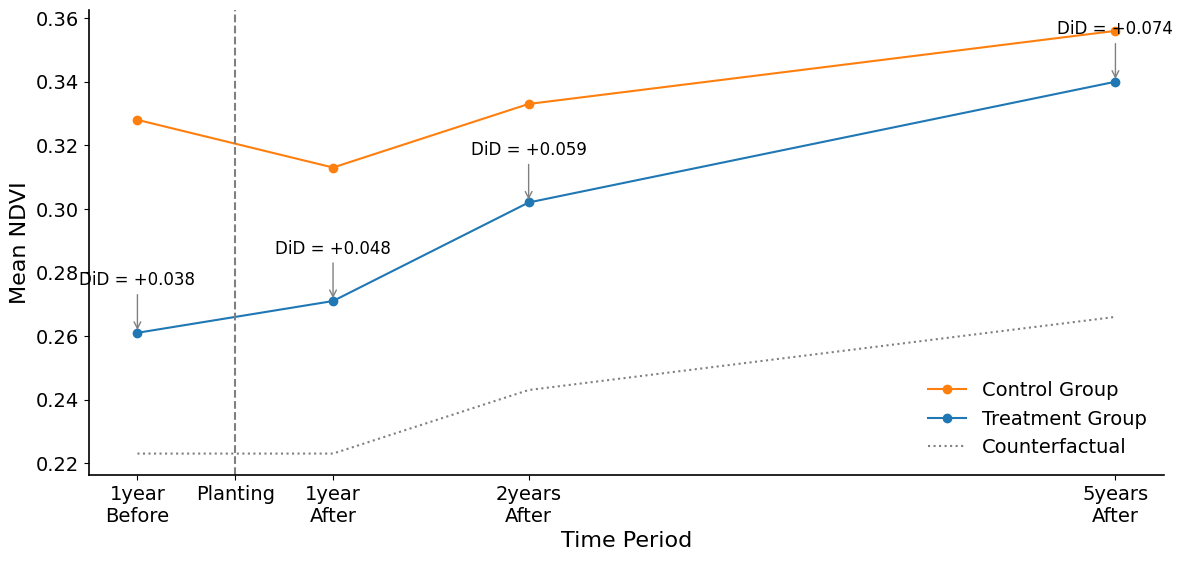

In [ ]:

palette = sns.color_palette()
color_polygon = palette[0]
color_buffer  = palette[1]

time_labels  = ['1year\nBefore', '1year\nAfter', '2years\nAfter', '5years\nAfter']
time_numeric = [0, 1, 2, 5]

# Coefficients from OLS
intercepts = {0: 0.290, 1: 0.265, 2: 0.265, 5: 0.265}
g          = {0: -0.105, 1: -0.090, 2: -0.090, 5: -0.090}
t          = {0:  0.038, 1:  0.048, 2:  0.068, 5:  0.091}
gt         = {0:  0.038, 1:  0.048, 2:  0.059, 5:  0.074}

# Our OLS formulas
control        = [intercepts[yr] + t[yr]                   for yr in time_numeric]
treatment      = [intercepts[yr] + g[yr] + t[yr] + gt[yr]  for yr in time_numeric]
counterfactual = [intercepts[yr] + g[yr] + t[yr]           for yr in time_numeric]

plt.figure(figsize=(12, 6))

plt.plot(time_numeric, control,        label='Control Group',   color=color_buffer,  marker='o')
plt.plot(time_numeric, treatment,      label='Treatment Group', color=color_polygon, marker='o')
plt.plot(time_numeric, counterfactual, label='Counterfactual',   color='grey',        linestyle='dotted')

plt.axvline(x=0.5, linestyle='--', color='grey')

for i, yr in enumerate(time_numeric):
    plt.annotate(f'DiD = {gt[yr]:+.3f}',
                 xy=(time_numeric[i], treatment[i]),
                 xytext=(time_numeric[i], treatment[i] + 0.015),
                 ha='center', fontsize=12,
                 arrowprops=dict(arrowstyle='->', color='grey'))

plt.xlabel('Time Period', fontsize=16)
plt.ylabel('Mean NDVI',    fontsize=16)

all_ticks  = time_numeric + [0.5]
all_labels = time_labels  + ['Planting']
plt.xticks(all_ticks, all_labels, fontsize=14, ha='center')
plt.yticks(fontsize=14)

plt.legend(prop={'size': 14}, frameon=False)
sns.despine(trim=False, left=False, bottom=False)

ax = plt.gca()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.grid(False)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.20)
plt.show()


In [ ]:
newdf=merged_df[merged_df["site_sqkm_derived"]<5]
#  change to greater again

In [ ]:

time_periods = ['1YearBefore','At_Planting', '1YearAfter', '2YearsAfter', '5YearsAfter']
df = newdf.copy()

# NDVI changes and ratios
for period in time_periods:
    df[f'NDVI_Change_Polygon_{period}'] = df[f'NDVI_Polygon_{period}'] - df['NDVI_Polygon_At_Planting']
    df[f'NDVI_Change_Buffer_{period}'] = df[f'NDVI_Buffer_{period}'] - df['NDVI_Buffer_At_Planting']


    df[f'NDVI_Ratio_{period}'] = df[f'NDVI_Change_Polygon_{period}'] / df[f'NDVI_Change_Buffer_{period}']

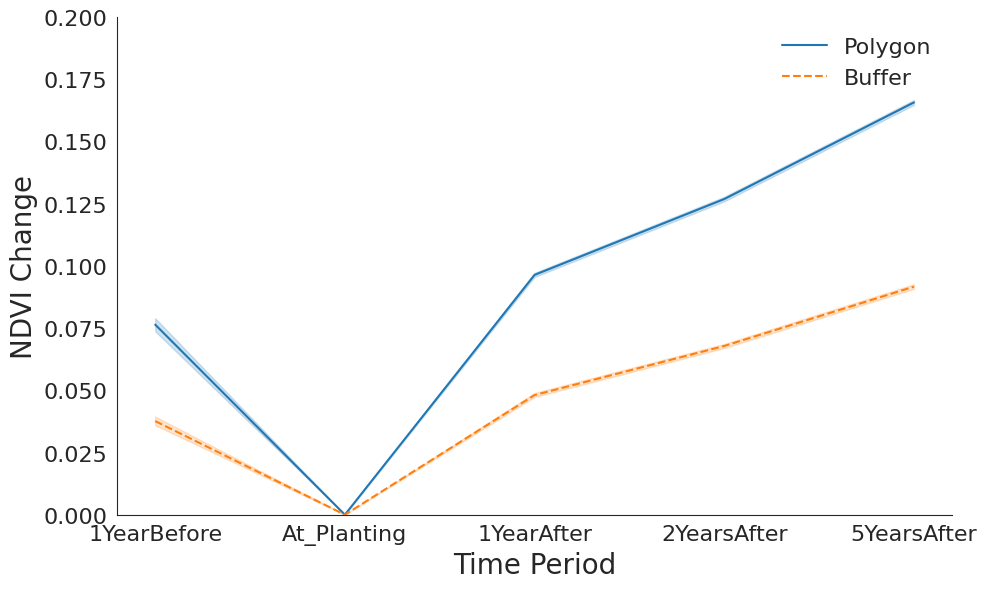

In [ ]:


sns.set_style("white")

# Melting  the data
melted_data_polygon = df.melt(
    value_vars=[f'NDVI_Change_Polygon_{period}' for period in time_periods],
    var_name='Time Period', value_name='NDVI Change Polygon'
)
melted_data_buffer = df.melt(
    value_vars=[f'NDVI_Change_Buffer_{period}' for period in time_periods],
    var_name='Time Period', value_name='NDVI Change Buffer'
)


melted_data_polygon['Time Period'] = melted_data_polygon['Time Period'] \
    .str.replace('NDVI_Change_Polygon_', '')
melted_data_buffer['Time Period'] = melted_data_buffer['Time Period'] \
    .str.replace('NDVI_Change_Buffer_', '')

plt.figure(figsize=(10, 6))
ax = plt.gca()

sns.lineplot(
    data=melted_data_polygon,
    x='Time Period', y='NDVI Change Polygon',
    label='Polygon', ax=ax
)
sns.lineplot(
    data=melted_data_buffer,
    x='Time Period', y='NDVI Change Buffer',
    label='Buffer', linestyle='--', ax=ax
)


ax.grid(False)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)


ax.set_facecolor('none')

ax.set_ylabel('NDVI Change', fontsize=20)
ax.set_xlabel('Time Period', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(0, 0.2)

ax.legend(prop={'size': 16}, frameon=False)

plt.tight_layout()
plt.show()
